In [1]:
import yaml
import pandas as pd
from trainer import *

In [2]:
import os
from datetime import datetime

def save_trained_model(filename, model, trainer, optimizer, config_setting, config_hyperparams):
    """
    Save the trained model that achieved the smallest dev_loss.
    
    Parameters:
    -----------
    filename : str
        The filename to save the model as (without extension)
    
    Returns:
    --------
    str
        The full path where the model was saved
    """
    # Get today's date in YYYY_MM_DD format
    today = datetime.now().strftime("%Y_%m_%d")
    
    # Create the directory structure: saved_models/{today's date}/
    save_dir = f"saved_models/{today}"
    os.makedirs(save_dir, exist_ok=True)
    
    # Create the full path
    model_path = f"{save_dir}/{filename}.pt"
    
    # Save the model with all relevant information
    torch.save({
        'epoch': trainer.best_epoch,
        'model_state_dict': trainer.best_performance_data['model_params_to_save'],
        'optimizer_state_dict': optimizer.state_dict(),
        'best_train_loss': trainer.best_performance_data['train_loss'],
        'best_dev_loss': trainer.best_performance_data['dev_loss'],
        'all_train_losses': trainer.all_train_losses,
        'all_dev_losses': trainer.all_dev_losses,
        'all_test_losses': trainer.all_test_losses,
        'warehouse_upper_bound': model.warehouse_upper_bound,
        'config_setting': config_setting,
        'config_hyperparams': config_hyperparams,
        'save_timestamp': datetime.now().isoformat()
    }, model_path)
    
    print(f"Model saved successfully!")
    print(f"Path: {model_path}")
    print(f"Best dev loss: {trainer.best_performance_data['dev_loss']:.6f}")
    print(f"Best epoch: {trainer.best_epoch + 1}")
    
    return model_path


In [3]:
# General function to make predictions using config files
import numpy as np

def make_predictions_from_config(model, device, config_setting_file=None, config_hyperparams_file=None, 
                                inventory_state_path=None, data_dir=None, time_period_idx=None, round_predictions=True):
    """
    Make predictions using a trained model by reading configuration files and automatically
    building the observation data structure.
    
    Parameters:
    -----------
    model : torch.nn.Module
        The trained model
    device : str
        Device to run inference on
    config_setting_file : str, optional
        Path to settings config file. If None, uses the current config files from the session.
    config_hyperparams_file : str, optional  
        Path to hyperparams config file. If None, uses the current config files from the session.
    inventory_state_path : str, optional
        Path to inventory state file. If None, uses default path.
    data_dir : str, optional
        Directory containing data files. If None, uses default path.
    time_period_idx : int, optional
        Time period index to use for prediction. If None, uses the last period.
    round_predictions : bool, optional
        Whether to round predictions to the nearest integer. Default is True.
        
    Returns:
    --------
    predictions : dict
        Dictionary containing model predictions
    """
    
    # Use current config if not provided
    if config_setting_file is None:
        config_setting_file = 'config_files/settings/vn2_round_1.yml'
    if config_hyperparams_file is None:
        config_hyperparams_file = 'config_files/policies_and_hyperparams/data_driven_net.yml'
    if inventory_state_path is None:
        inventory_state_path = 'vn2_processed_data/all_data/inventory_state.pt'
    if data_dir is None:
        data_dir = 'vn2_processed_data/all_data/'
    
    # Load configuration files
    print("Loading configuration files...")
    with open(config_setting_file, 'r') as file:
        config_setting = yaml.safe_load(file)
    
    with open(config_hyperparams_file, 'r') as file:
        config_hyperparams = yaml.safe_load(file)
    
    # Extract configuration parameters
    setting_keys = 'seeds', 'test_seeds', 'problem_params', 'params_by_dataset', 'observation_params', 'store_params', 'warehouse_params', 'echelon_params', 'sample_data_params'
    hyperparams_keys = 'trainer_params', 'optimizer_params', 'nn_params'
    seeds, test_seeds, problem_params, params_by_dataset, observation_params, store_params, warehouse_params, echelon_params, sample_data_params = [
        config_setting[key] for key in setting_keys
    ]
    
    observation_params = DefaultDict(lambda: None, observation_params)
    
    # Load data files
    print("Loading data files...")
    inventory_data = torch.load(inventory_state_path, map_location=device)
    
    # Load data files based on store_params configuration
    data_files = {}
    if 'demand' in store_params and 'file_location' in store_params['demand']:
        data_files['demands'] = torch.load(data_dir + store_params['demand']['file_location'].split('/')[-1], map_location=device)
    
    if 'stockout' in store_params and 'file_location' in store_params['stockout']:
        data_files['stockouts'] = torch.load(data_dir + store_params['stockout']['file_location'].split('/')[-1], map_location=device)
    
    # Load time features
    if observation_params['time_features_file']:
        date_features = pd.read_csv(data_dir + observation_params['time_features_file'].split('/')[-1])
        # Create a mapping from feature names to column indices
        feature_to_index = {}
        for i, col in enumerate(date_features.columns):
            if col != 'date':  # Skip the date column
                feature_to_index[col] = i - 1  # Adjust for dropped date column
        
        # Create tensor with features in the order specified by config
        if observation_params['time_features']:
            ordered_features = []
            for feature_name in observation_params['time_features']:
                if feature_name in feature_to_index:
                    col_idx = feature_to_index[feature_name]
                    ordered_features.append(date_features.iloc[:, col_idx + 1].values)  # +1 because we skip date column
                else:
                    print(f"Warning: Feature '{feature_name}' not found in date features")
                    ordered_features.append(np.zeros(len(date_features)))
            
            date_features_tensor = torch.tensor(np.column_stack(ordered_features), dtype=torch.float32).to(device)
        else:
            # Fallback to original method if no specific order is specified
            date_features_tensor = torch.tensor(date_features.drop('date', axis=1).values, dtype=torch.float32).to(device)
    
    # Load product features
    if 'product_features' in store_params and 'file_location' in store_params['product_features']:
        product_features = pd.read_csv(data_dir + store_params['product_features']['file_location'].split('/')[-1])
        product_features_tensor = torch.tensor(product_features.values, dtype=torch.float32).to(device)
    
    # Determine time period
    if time_period_idx is None:
        # Use the last period
        if 'demands' in data_files:
            time_period_idx = data_files['demands'].shape[2] - 1
        else:
            time_period_idx = -1
    
    # Prepare past demands
    if 'demands' in data_files and observation_params['demand']['past_periods'] > 0:
        past_periods = observation_params['demand']['past_periods']
        start_idx = max(0, time_period_idx - past_periods + 1)
        past_demands = data_files['demands'][:, :, start_idx:time_period_idx+1]
        # Pad with zeros if we don't have enough history
        if past_demands.shape[2] < past_periods:
            padding = torch.zeros(past_demands.shape[0], past_demands.shape[1], past_periods - past_demands.shape[2], device=device)
            past_demands = torch.cat([padding, past_demands], dim=2)
    
    # Prepare past stockouts
    if 'stockouts' in data_files and 'stockout' in observation_params and observation_params['stockout']['past_periods'] > 0:
        past_periods = observation_params['stockout']['past_periods']
        start_idx = max(0, time_period_idx - past_periods + 1)
        past_stockouts = data_files['stockouts'][:, :, start_idx:time_period_idx+1]
        # Pad with zeros if we don't have enough history
        if past_stockouts.shape[2] < past_periods:
            padding = torch.zeros(past_stockouts.shape[0], past_stockouts.shape[1], past_periods - past_stockouts.shape[2], device=device)
            past_stockouts = torch.cat([padding, past_stockouts], dim=2)
    
    # Prepare time features for the current period
    if observation_params['time_features']:
        time_features_expanded = date_features_tensor[time_period_idx:time_period_idx+1].expand(inventory_data.shape[0], -1)
    
    # Prepare product features
    if 'product_features' in store_params and 'features' in store_params['product_features']:
        feature_indices = []
        for feature in store_params['product_features']['features']:
            if feature in product_features.columns:
                feature_indices.append(product_features.columns.get_loc(feature))
        product_features_subset = product_features_tensor[:, feature_indices]
    
    # Create static features from store_params
    static_features = {}
    if observation_params['include_static_features']:
        for feature_name, include in observation_params['include_static_features'].items():
            if include and feature_name in store_params:
                if 'value' in store_params[feature_name]:
                    value = store_params[feature_name]['value']
                    static_features[feature_name] = torch.full(
                        (inventory_data.shape[0], inventory_data.shape[1]), 
                        value, 
                        device=device
                    )
    
    # Build observation dictionary
    observation = {
        'store_inventories': inventory_data,
        'current_period': torch.tensor([time_period_idx], device=device),
    }
    
    # Add past demands
    if 'past_demands' in locals():
        observation['past_demands'] = past_demands
    
    # Add past stockouts
    if 'past_stockouts' in locals():
        observation['past_stockouts'] = past_stockouts
    
    # Add product features
    if 'product_features_subset' in locals():
        observation['product_features'] = product_features_subset
    
    # Add static features
    observation.update(static_features)
    
    # Add time features
    if observation_params['time_features']:
        for i, feature_name in enumerate(observation_params['time_features']):
            if i < time_features_expanded.shape[1]:
                observation[feature_name] = time_features_expanded[:, i:i+1]
    
    # Add internal data
    internal_data = {}
    if 'demands' in data_files:
        internal_data['demands'] = data_files['demands']
    if 'stockouts' in data_files:
        internal_data['stockouts'] = data_files['stockouts']
    
    internal_data['period_shift'] = observation_params['demand'].get('period_shift', 0)
    observation['internal_data'] = internal_data
    
    # Make prediction
    print("Making prediction...")
    model.eval()
    with torch.no_grad():
        predictions = model(observation)
    
    # Round predictions if requested
    if round_predictions:
        predictions['stores'] = torch.round(predictions['stores'])
    
    print(f"Predictions shape: {predictions['stores'].shape}")
    print(f"Sample predictions (first 10): {predictions['stores'][:10]}")
    print(f"Mean of predictions: {predictions['stores'].mean()}")
    print(f"Time period used: {time_period_idx}")
    print(f"Predictions rounded: {round_predictions}")
    
    return predictions

# Convenience function using current session's config
def make_predictions_with_current_model_general(model, device, round_predictions=True):
    """
    Make predictions using the current session's configuration and model.
    """
    return make_predictions_from_config(model, device, round_predictions=round_predictions)

# Function to save predictions in submission format
def save_predictions_to_submission_format(predictions, output_filename="predictions_submission.csv", 
                                        reference_data_path="vn2_data/Week 0 - 2024-04-08 - Initial State.csv"):
    """
    Save model predictions in the submission template format.
    
    Parameters:
    -----------
    predictions : dict
        Dictionary containing model predictions with 'stores' key
    output_filename : str
        Name of the output CSV file
    reference_data_path : str
        Path to reference data file to get Store and Product mapping
    """
    import pandas as pd
    
    # Load reference data to get Store and Product mapping
    print(f"Loading reference data from {reference_data_path}...")
    reference_data = pd.read_csv(reference_data_path)
    
    # Extract Store and Product columns
    store_product_mapping = reference_data[['Store', 'Product']].copy()
    
    # Get predictions tensor and convert to numpy
    predictions_tensor = predictions['stores'].cpu().numpy()  # Convert to CPU numpy array
    
    # Flatten predictions to match the number of store-product combinations
    # predictions_tensor shape is [batch_size, n_stores, n_warehouses]
    # We need to flatten it to match the number of rows in reference data
    if predictions_tensor.ndim == 3:
        # If 3D, flatten the last two dimensions
        predictions_flat = predictions_tensor.reshape(-1)
    else:
        # If already 2D or 1D, use as is
        predictions_flat = predictions_tensor.flatten()
    
    # Ensure we have the right number of predictions
    if len(predictions_flat) != len(store_product_mapping):
        print(f"Warning: Number of predictions ({len(predictions_flat)}) doesn't match number of store-product combinations ({len(store_product_mapping)})")
        # Truncate or pad as needed
        if len(predictions_flat) > len(store_product_mapping):
            predictions_flat = predictions_flat[:len(store_product_mapping)]
        else:
            # Pad with zeros if we have fewer predictions
            padding = np.zeros(len(store_product_mapping) - len(predictions_flat))
            predictions_flat = np.concatenate([predictions_flat, padding])
    
    # Add predictions to the dataframe
    store_product_mapping['Prediction'] = predictions_flat.astype(int)
    
    # Save to CSV
    print(f"Saving predictions to {output_filename}...")
    store_product_mapping.to_csv(output_filename, index=False)
    
    print(f"Saved {len(store_product_mapping)} predictions to {output_filename}")
    print(f"Sample predictions:")
    print(store_product_mapping.head(10))
    print(f"Prediction statistics:")
    print(f"  Mean: {store_product_mapping['Prediction'].mean():.2f}")
    print(f"  Min: {store_product_mapping['Prediction'].min()}")
    print(f"  Max: {store_product_mapping['Prediction'].max()}")
    print(f"  Non-zero predictions: {(store_product_mapping['Prediction'] > 0).sum()}")
    
    return store_product_mapping

NameError: name 'inventory_state_path' is not defined

In [4]:
# Simple function to make predictions with the current trained model
import numpy as np

def make_predictions_with_current_model(model, device, round_predictions=True):
    """
    Make predictions using the currently loaded model and your inventory state data.
    This assumes the model is already trained and loaded in the current session.
    
    Parameters:
    -----------
    model : torch.nn.Module
        The trained model
    device : str
        Device to run inference on
    round_predictions : bool, optional
        Whether to round predictions to the nearest integer. Default is True.
    """
    
    # Load your inventory state data
    print("Loading inventory state data...")
    inventory_data = torch.load('vn2_processed_data/all_data/inventory_state.pt', map_location=device)
    
    # Load other required data files
    sales_data = torch.load('vn2_processed_data/all_data/sales.pt', map_location=device)
    stock_data = torch.load('vn2_processed_data/all_data/stock.pt', map_location=device)
    time_product_data = torch.load('vn2_processed_data/all_data/time_product_features.pt', map_location=device)
    
    # Load CSV data
    date_features = pd.read_csv('vn2_processed_data/all_data/date_features.csv')
    product_features = pd.read_csv('vn2_processed_data/all_data/product_features.csv')
    
    # Convert CSV data to tensors with correct feature mapping
    # Create a mapping from feature names to column indices
    feature_to_index = {}
    for i, col in enumerate(date_features.columns):
        if col != 'date':  # Skip the date column
            feature_to_index[col] = i - 1  # Adjust for dropped date column
    
    # Create tensor with features in the order specified by config
    ordered_features = []
    config_time_features = ['days_from_christmas', 'day_of_month', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12']
    for feature_name in config_time_features:
        if feature_name in feature_to_index:
            col_idx = feature_to_index[feature_name]
            ordered_features.append(date_features.iloc[:, col_idx + 1].values)  # +1 because we skip date column
        else:
            print(f"Warning: Feature '{feature_name}' not found in date features")
            ordered_features.append(np.zeros(len(date_features)))
    
    date_features_tensor = torch.tensor(np.column_stack(ordered_features), dtype=torch.float32).to(device)
    product_features_tensor = torch.tensor(product_features.values, dtype=torch.float32).to(device)
    
    # Prepare observation data for the last time period
    # The model expects 16 past periods, so we'll use the last 16 periods
    past_periods = 16
    last_period_idx = -past_periods  # Start from 16 periods ago
    
    # Prepare past demands (16 periods)
    past_demands = sales_data[:, :, last_period_idx:]  # Shape: [599, 1, 16]
    
    # Prepare past stockouts (16 periods) - assuming stockouts are derived from stock data
    past_stockouts = stock_data[:, :, last_period_idx:]  # Shape: [599, 1, 16]
    
    # Prepare time features for the last period
    last_period_time_features = date_features_tensor[-1:]  # Shape: [1, 16] (last row)
    # Expand to match batch size
    time_features_expanded = last_period_time_features.expand(inventory_data.shape[0], -1)  # Shape: [599, 16]
    
    # Prepare product features (only Store and Product as specified in config)
    product_features_subset = product_features_tensor[:, :2]  # Only first 2 columns: Store, Product
    
    # Create static features (these are constant across all samples based on config)
    holding_costs = torch.full((inventory_data.shape[0], inventory_data.shape[1]), 0.2, device=device)  # [599, 1]
    underage_costs = torch.full((inventory_data.shape[0], inventory_data.shape[1]), 1.0, device=device)  # [599, 1]
    lead_times = torch.full((inventory_data.shape[0], inventory_data.shape[1]), 2, device=device)  # [599, 1]
    
    observation = {
        'store_inventories': inventory_data,  # [599, 1, 2] - use actual inventory data
        'past_demands': past_demands,  # [599, 1, 16]
        'past_stockouts': past_stockouts,  # [599, 1, 16]
        'product_features': product_features_subset,  # [599, 2] - only Store and Product
        'holding_costs': holding_costs,  # [599, 1] - static feature
        'underage_costs': underage_costs,  # [599, 1] - static feature
        'lead_times': lead_times,  # [599, 1] - static feature
        'days_from_christmas': time_features_expanded[:, 0:1],  # [599, 1] - index 0
        'day_of_month': time_features_expanded[:, 1:2],  # [599, 1] - index 1
        'month_1': time_features_expanded[:, 2:3],  # [599, 1] - index 2
        'month_2': time_features_expanded[:, 3:4],  # [599, 1] - index 3
        'month_3': time_features_expanded[:, 4:5],  # [599, 1] - index 4
        'month_4': time_features_expanded[:, 5:6],  # [599, 1] - index 5
        'month_5': time_features_expanded[:, 6:7],  # [599, 1] - index 6
        'month_6': time_features_expanded[:, 7:8],  # [599, 1] - index 7
        'month_7': time_features_expanded[:, 8:9],  # [599, 1] - index 8
        'month_8': time_features_expanded[:, 9:10],  # [599, 1] - index 9
        'month_9': time_features_expanded[:, 10:11],  # [599, 1] - index 10
        'month_10': time_features_expanded[:, 11:12],  # [599, 1] - index 11
        'month_11': time_features_expanded[:, 12:13],  # [599, 1] - index 12
        'month_12': time_features_expanded[:, 13:14],  # [599, 1] - index 13
        'current_period': torch.tensor([last_period_idx], device=device),
    }

    # print(f'observation: {observation["month_12"]}')
    # Add internal data (using the same structure as in training)
    internal_data = {
        'demands': sales_data,
        'period_shift': 0,  # Adjust as needed
    }
    
    observation['internal_data'] = internal_data
    
    # Make prediction using the current model
    print("Making prediction...")
    model.eval()  # Set to evaluation mode  
    with torch.no_grad():
        predictions = model(observation)
    
    # Round predictions if requested
    if round_predictions:
        predictions['stores'] = torch.round(predictions['stores'])
    
    print(f"Predictions shape: {predictions['stores'].shape}")
    print(f"Sample predictions (first 10): {predictions['stores'][:10]}")
    print(f"Mean of predictions: {predictions['stores'].mean()}")
    print(f"Predictions rounded: {round_predictions}")
    print(f"Past stockouts: {past_stockouts[:10]}")
    print(f"Past demands: {past_demands[:10]}")
    print(f"Inventory data: {observation['store_inventories'][:10]}")
    print(f"Holding costs: {observation['holding_costs'][:10]}")
    print(f"Underage costs: {observation['underage_costs'][:10]}")
    print(f"Lead times: {observation['lead_times'][:10]}")
    
    return predictions


### Setting the config files
In this example, we will apply a Vanilla Neural Network to a setting of one store under a lost demand assumption.
Go to the respective config files to change the hyperparameters of the neural network or the setting

In [5]:
config_setting_file = 'config_files/settings/vn2_round_1.yml'
# config_setting_file = 'config_files/settings/one_store_lost.yml'
config_hyperparams_file = 'config_files/policies_and_hyperparams/data_driven_net.yml'
# config_hyperparams_file = 'config_files/policies_and_hyperparams/vanilla_one_store.yml'

In [6]:
with open(config_setting_file, 'r') as file:
    config_setting = yaml.safe_load(file)

with open(config_hyperparams_file, 'r') as file:
    config_hyperparams = yaml.safe_load(file)

setting_keys = 'seeds', 'test_seeds', 'problem_params', 'params_by_dataset', 'observation_params', 'store_params', 'warehouse_params', 'echelon_params', 'sample_data_params'
hyperparams_keys = 'trainer_params', 'optimizer_params', 'nn_params'
seeds, test_seeds, problem_params, params_by_dataset, observation_params, store_params, warehouse_params, echelon_params, sample_data_params = [
    config_setting[key] for key in setting_keys
    ]

trainer_params, optimizer_params, nn_params = [config_hyperparams[key] for key in hyperparams_keys]
observation_params = DefaultDict(lambda: None, observation_params)

device = "cuda:0" if torch.cuda.is_available() else "cpu"
dataset_creator = DatasetCreator()

# For realistic data, train, dev and test sets correspond to the same products, but over disjoint periods.
# We will therefore create one scenario, and then split the data into train, dev and test sets by 
# "copying" all non-period related information, and then splitting the period related information
if sample_data_params['split_by_period']:
    
    scenario = Scenario(
        periods=None,  # period info for each dataset is given in sample_data_params
        problem_params=problem_params, 
        store_params=store_params, 
        warehouse_params=warehouse_params, 
        echelon_params=echelon_params, 
        num_samples=params_by_dataset['train']['n_samples'],  # in this case, num_samples=number of products, which has to be the same across all datasets
        observation_params=observation_params, 
        seeds=seeds
        )
    
    train_dataset, dev_dataset, test_dataset = dataset_creator.create_datasets(
        scenario, 
        split=True, 
        by_period=True, 
        periods_for_split=[sample_data_params[k] for  k in ['train_periods', 'dev_periods', 'test_periods']],)

# For synthetic data, we will first create a scenario that we will divide into train and dev sets by sample index.
# Then, we will create a separate scenario for the test set, which will be exaclty the same as the previous scenario, 
# but with different seeds to generate demand traces, and with a longer time horizon.
# One can use this method of generating scenarios to train a model using some specific problem primitives, 
# and then test it on a different set of problem primitives, by simply creating a new scenario with the desired primitives.
else:
    max_periods = max(params_by_dataset['train']['periods'], params_by_dataset['dev']['periods'])
    scenario = Scenario(
        periods=max_periods, 
        # periods=params_by_dataset['train']['periods'], 
        problem_params=problem_params, 
        store_params=store_params, 
        warehouse_params=warehouse_params, 
        echelon_params=echelon_params, 
        num_samples=params_by_dataset['train']['n_samples'] + params_by_dataset['dev']['n_samples'], 
        observation_params=observation_params, 
        seeds=seeds
        )

    train_dataset, dev_dataset = dataset_creator.create_datasets(scenario, split=True, by_sample_indexes=True, sample_index_for_split=params_by_dataset['dev']['n_samples'])

    scenario = Scenario(
        params_by_dataset['test']['periods'], 
        problem_params, 
        store_params, 
        warehouse_params, 
        echelon_params, 
        params_by_dataset['test']['n_samples'], 
        observation_params, 
        test_seeds
        )

    test_dataset = dataset_creator.create_datasets(scenario, split=False)

train_loader = DataLoader(train_dataset, batch_size=params_by_dataset['train']['batch_size'], shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=params_by_dataset['dev']['batch_size'], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=params_by_dataset['test']['batch_size'], shuffle=False)
data_loaders = {'train': train_loader, 'dev': dev_loader, 'test': test_loader}

neural_net_creator = NeuralNetworkCreator
model = neural_net_creator().create_neural_network(scenario, nn_params, device=device)

loss_function = PolicyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=optimizer_params['learning_rate'])

simulator = Simulator(device=device)
trainer = Trainer(device=device)

# We will create a folder for each day of the year, and a subfolder for each model
# When executing with different problem primitives (i.e. instance), it might be useful to create an additional subfolder for each instance
trainer_params['base_dir'] = 'saved_models'
trainer_params['save_model_folders'] = [trainer.get_year_month_day(), nn_params['name']]

# We will simply name the model with the current time stamp
trainer_params['save_model_filename'] = trainer.get_time_stamp()

# Load previous model if load_model is set to True in the config file
if trainer_params['load_previous_model']:
    print(f'Loading model from {trainer_params["load_model_path"]}')
    model, optimizer = trainer.load_model(model, optimizer, trainer_params['load_model_path'])

/user/ma4177/Neural_inventory_control/data_handling.py:188: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(demand)


In [6]:
print(train_loader.dataset.data.keys())
print(train_loader.dataset.data['product_features'].shape)
print(dev_loader.dataset.data['day_of_month'].shape)

dict_keys(['underage_costs', 'holding_costs', 'lead_times', 'initial_inventories', 'product_features', 'demands', 'stockouts', 'days_from_christmas', 'day_of_month', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12'])
torch.Size([599, 2])
torch.Size([599, 1, 53])


### Training

In [7]:
# optional: load a model to continue training
load_model = False
if load_model:
    model_filename = "saved_models/2025_10_04/model_1.pt"
    model, optimizer = trainer.load_model(model, optimizer, model_filename)


In [ ]:
trainer.train(
    trainer_params['epochs'], 
    loss_function, simulator, 
    model, 
    data_loaders, 
    optimizer, 
    problem_params, 
    observation_params, 
    params_by_dataset, 
    trainer_params)

epoch: 1
Average per-period train loss: 0.03868479784694761
Average per-period dev loss: 0.0
Best per-period dev loss: 0.0
epoch: 2
Average per-period train loss: 0.0
Average per-period dev loss: 0
Best per-period dev loss: 0.0
epoch: 3
Average per-period train loss: 0.0
Average per-period dev loss: 0
Best per-period dev loss: 0.0
epoch: 4
Average per-period train loss: 0.0
Average per-period dev loss: 0
Best per-period dev loss: 0.0
epoch: 5
Average per-period train loss: 0.0
Average per-period dev loss: 0
Best per-period dev loss: 0.0
epoch: 6
Average per-period train loss: 0.0
Average per-period dev loss: 0
Best per-period dev loss: 0.0
epoch: 7
Average per-period train loss: 0.0
Average per-period dev loss: 0
Best per-period dev loss: 0.0
epoch: 8
Average per-period train loss: 0.0
Average per-period dev loss: 0
Best per-period dev loss: 0.0
epoch: 9
Average per-period train loss: 0.0
Average per-period dev loss: 0
Best per-period dev loss: 0.0
epoch: 10
Average per-period train lo

In [ ]:
# Optional:Save the trained model
save_model = False
if save_model:
    # The function will save the model that achieved the smallest dev_loss during training
    model_filename = "model_32_demands"
    saved_model_path = save_trained_model(model_filename, trainer, optimizer, config_setting, config_hyperparams)


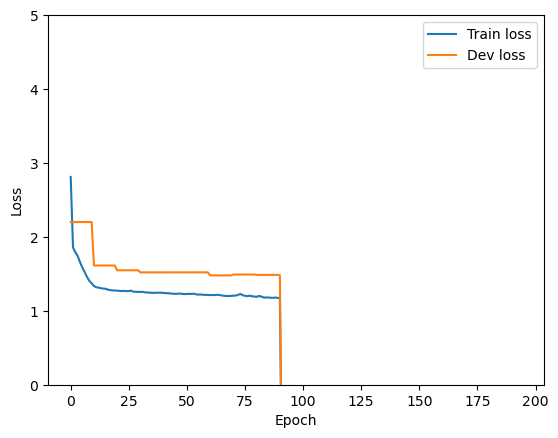

In [28]:
# plot the losses
ymin, ymax = 0, 5  # set the y-axis limit for the plot
trainer.plot_losses(ymin=ymin, ymax=ymax)

### Evaluate on test set

In [40]:
load_model_for_test = True
if load_model_for_test:
    model_filename = "saved_models/2025_10_04/model_1.pt"
    model, optimizer = trainer.load_model(model, optimizer, model_filename)
    print(f"Loaded model from {model_filename}")

Loaded model from saved_models/2025_10_04/model_1.pt


In [63]:
average_test_loss, average_test_loss_to_report = trainer.test(
    loss_function, 
    simulator, 
    model, 
    data_loaders, 
    optimizer, 
    problem_params, 
    observation_params, 
    params_by_dataset, 
    discrete_allocation=False
    )

In [42]:
# Create and evaluate JustInTime model for comparison
print("Creating JustInTime model for comparison...")

# Create JustInTime model with the same scenario and parameters
justintime_nn_params = {
    'name': 'just_in_time',
    'inner_layer_activations': {'master': 'relu'},
    'output_layer_activation': {'master': None},
    'neurons_per_hidden_layer': {'master': []},
    'output_sizes': {'master': None},
    'initial_bias': {'master': None}
}

justintime_model = NeuralNetworkCreator().create_neural_network(scenario, justintime_nn_params, device=device)

# Evaluate JustInTime model
print("Evaluating JustInTime model...")
justintime_test_loss, justintime_test_loss_to_report = trainer.test(
    loss_function, 
    simulator, 
    justintime_model, 
    data_loaders, 
    optimizer, 
    problem_params, 
    observation_params, 
    params_by_dataset, 
    discrete_allocation=True
)

print(f'JustInTime Average per-period test loss: {justintime_test_loss_to_report}')


Creating JustInTime model for comparison...
Evaluating JustInTime model...
JustInTime Average per-period test loss: -3.293201086778618


In [64]:
# Print comparison between models
print("\n" + "="*60)
print("MODEL COMPARISON RESULTS")
print("="*60)
print(f"Trained Model Test Loss:     {average_test_loss_to_report:.6f}")
print(f"JustInTime Model Test Loss:  {justintime_test_loss_to_report:.6f}")
print(f"Difference:                  {average_test_loss_to_report - justintime_test_loss_to_report:.6f}")

if average_test_loss_to_report < justintime_test_loss_to_report:
    print("✓ Trained model performs BETTER than JustInTime (lower loss)")
    improvement = ((justintime_test_loss_to_report - average_test_loss_to_report) / abs(justintime_test_loss_to_report)) * 100
    print(f"  Improvement: {improvement:.2f}%")
else:
    print("⚠ JustInTime performs BETTER than trained model (lower loss)")
    gap = ((average_test_loss_to_report) / justintime_test_loss_to_report) * 100
    print(f"  Fraction of JustInTime loss: {gap:.2f}%")
print("="*60)



MODEL COMPARISON RESULTS
Trained Model Test Loss:     -1.864408
JustInTime Model Test Loss:  -3.293201
Difference:                  1.428793
⚠ JustInTime performs BETTER than trained model (lower loss)
  Fraction of JustInTime loss: 56.61%


In [44]:
print(f'Average per-period test loss: {average_test_loss_to_report}')

Average per-period test loss: -1.8661362943549706


In [68]:
# Use with different config files
predictions = make_predictions_from_config(
    model, device,
    config_setting_file=config_setting_file,
    config_hyperparams_file=config_hyperparams_file,
    inventory_state_path='vn2_processed_data/all_data/inventory_state.pt',
    data_dir='vn2_processed_data/all_data/',
    round_predictions=True
)

save_predictions_to_submission_format(predictions, output_filename="predictions/submission.csv", reference_data_path="vn2_data/Week 0 - 2024-04-08 - Initial State.csv")

Loading configuration files...
Loading data files...
Making prediction...
Predictions shape: torch.Size([599, 1, 1])
Sample predictions (first 10): tensor([[[ 1.]],

        [[ 1.]],

        [[10.]],

        [[ 6.]],

        [[ 2.]],

        [[ 2.]],

        [[12.]],

        [[ 1.]],

        [[ 3.]],

        [[ 7.]]], device='cuda:0')
Mean of predictions: 2.6193654537200928
Time period used: 156
Predictions rounded: True
Loading reference data from vn2_data/Week 0 - 2024-04-08 - Initial State.csv...
Saving predictions to predictions/submission.csv...
Saved 599 predictions to predictions/submission.csv
Sample predictions:
   Store  Product  Prediction
0      0      126           1
1      0      182           1
2      1      124          10
3      2      124           6
4      2      126           2
5      3      126           2
6      4      124          12
7      4      126           1
8      5      126           3
9      6      124           7
Prediction statistics:
  Mean: 2.

,Store,Product,Prediction
0,0,126,1
1,0,182,1
2,1,124,10
3,2,124,6
4,2,126,2
...,...,...,...
594,64,193,1
595,64,238,1
596,65,126,2
597,66,124,5


In [67]:
# Run the prediction
print("Making predictions with current model...")
predictions = make_predictions_with_current_model(model, device)


Making predictions with current model...
Loading inventory state data...
Making prediction...
Predictions shape: torch.Size([599, 1, 1])
Sample predictions (first 10): tensor([[[ 0.5762]],

        [[ 1.3479]],

        [[ 9.6040]],

        [[ 5.8701]],

        [[ 2.0314]],

        [[ 2.4411]],

        [[11.7404]],

        [[ 0.5272]],

        [[ 2.7196]],

        [[ 7.1262]]], device='cuda:0')
Mean of predictions: 2.585651397705078
Past stockouts: tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]],

 